<a href="https://colab.research.google.com/github/E1250/cnn_cv-ref/blob/main/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Lecture - https://www.youtube.com/watch?v=pExbqne2mDs&list=PLyhJeMedQd9T-jQgrOxKiuJ_Q0plUeMfF&index=4
* GitHub - https://github.com/AhmedIbrahimai/denoising-autoencoder-in-python-computer-vision/blob/main/DAE.ipynb


## Denoising AE

In [1]:
import numpy as np
from keras.datasets import mnist

In [2]:
(X_train , _) ,(X_test, _) = mnist.load_data()
X_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

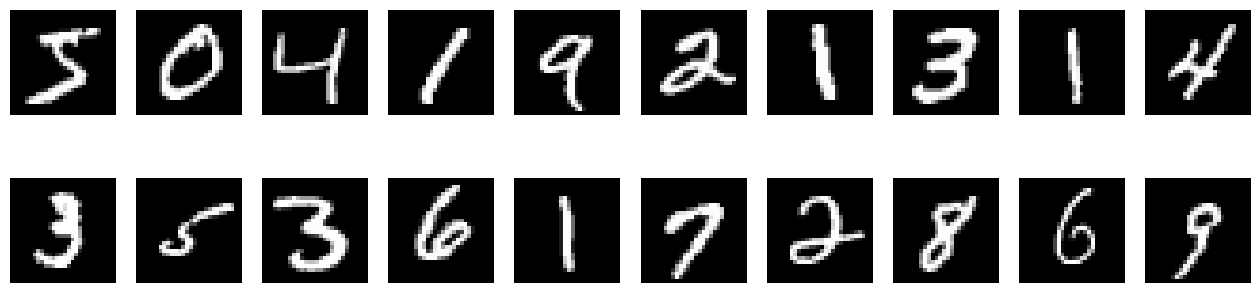

In [3]:
# Plotting data
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2,10, figsize = (16, 4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train[count], cmap = 'gray')
        axes[i,j].axis('off')
        count +=1

In [8]:
# Normalizing
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape

(60000, 28, 28)

In [5]:
# Adding Noise to the data
noise_factor = 0.1 # Increase it to increase the noise

X_train_noise = X_train + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_test.shape)

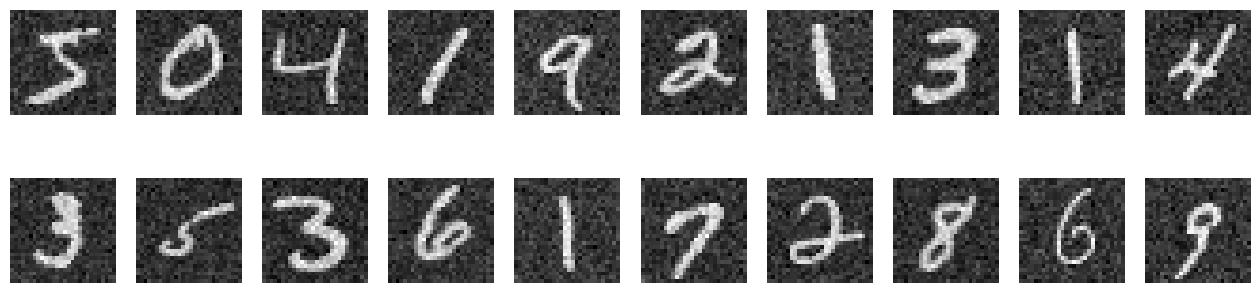

In [7]:
fig, axes = plt.subplots(2,10, figsize = (16,4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train_noise[count], cmap = 'gray')
        axes[i,j].axis('off')
        count += 1

In [9]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 28 , 28, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 28, 28, 1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

## Model

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [11]:
# Encoder (Compressing Data)
encoder_input = Input(shape = X_train.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)

In [12]:
# Decoder (DeCompressing Data)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(x)

In [13]:
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)    

In [16]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')
checkpoint = ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only=False, verbose = 1)

# Note the Data to Fit (Noised, Normal)
history = autoencoder.fit(X_train_noise, X_train, batch_size = 128, epochs = 50, callbacks = checkpoint, validation_split = 0.25, verbose = 2)


Epoch 45: val_loss did not improve from 0.00346
352/352 - 3s - loss: 0.0035 - val_loss: 0.0035 - 3s/epoch - 9ms/step
Epoch 46/50

Epoch 46: val_loss improved from 0.00346 to 0.00346, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0035 - val_loss: 0.0035 - 3s/epoch - 8ms/step
Epoch 47/50

Epoch 47: val_loss did not improve from 0.00346
352/352 - 3s - loss: 0.0035 - val_loss: 0.0035 - 3s/epoch - 7ms/step
Epoch 48/50

Epoch 48: val_loss did not improve from 0.00346
352/352 - 3s - loss: 0.0035 - val_loss: 0.0035 - 3s/epoch - 8ms/step
Epoch 49/50

Epoch 49: val_loss improved from 0.00346 to 0.00346, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0035 - val_loss: 0.0035 - 3s/epoch - 9ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 0.00346
352/352 - 3s - loss: 0.0035 - val_loss: 0.0035 - 3s/epoch - 9ms/step


In [17]:
# Load best performance model
from keras.models import load_model

autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)    

In [18]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)

    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count], cmap = 'gray')
            axes[i,j].axis('off')
            count+=1

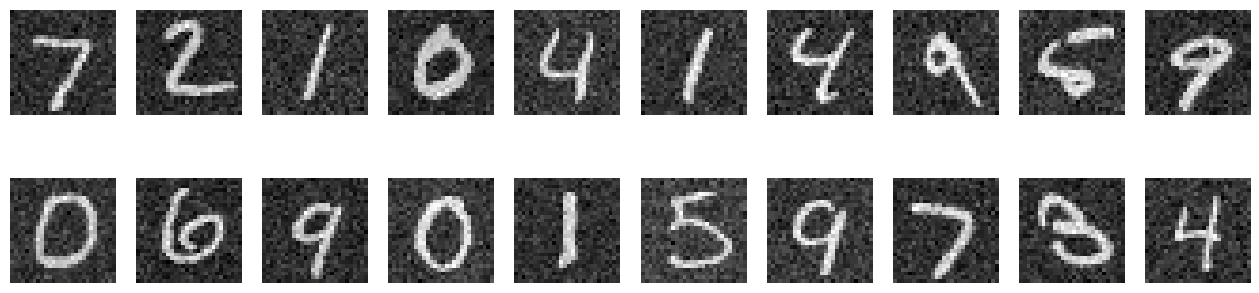

In [20]:
# Noised Data
visualize_data(X_test_noise[:20], 2,10)

1/1 [==============================] - 0s 19ms/step


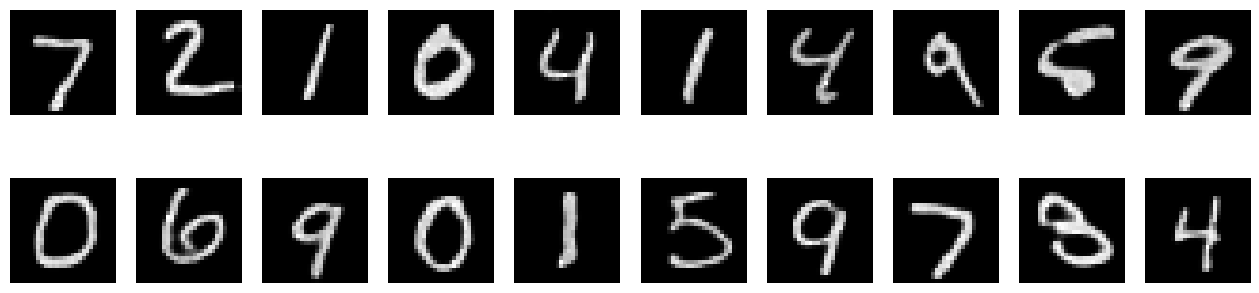

In [23]:
# Note that we are using the full Autoencoder to perdict (It is possible)
pred = autoencoder.predict(X_test_noise[:20])
pred.shape

# Denoised Data
visualize_data(pred, 2, 10)